# Sales Data Analysis
In this notebook, we perform a comprehensive analysis of the sales data to uncover patterns, trends, and potentially predict future sales. We use Python libraries such as Pandas for data manipulation, Plotly for interactive visualization, and Facebook Prophet for forecasting future sales.


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


## Data Loading
The dataset is loaded into a Pandas DataFrame. The dataset includes details about sales transactions including dates, customer information, product categories, and sales categories and figures.


In [4]:
URL='train.csv'
df=pd.read_csv(URL)

## Initial Data Overview
Let's take a preliminary look at our data to understand its structure and some basic statistics.

In [5]:
df.head()

Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category Sub-Category  \
0      42420.0  South  FUR-BO-10001798        Furniture    Bookcases   
1      42420.0  South  FUR-CH-10000454        Furniture       Chairs   
2      90036.0   West  OFF-LA-10000240  Office Supplies       Labels   
3      33311.0  South  FUR-TA-10000577        Furniture       Tables   
4      33311.0  South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  
0                  Bush Somerset Collection Bookcase  261.9600  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400  
2  Self-Adhesive Address Labels for Typewriters b...   14.6200  
3      Bretford CR4500 Series Slim Rectangular Table  957.5775  
4                     Eldon Fold 'N Roll Cart System   22.3680

In [6]:
df.shape

(9800, 18)

In [7]:
df.describe(include="O")

Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
count             9800        9800        9800            9800        9800   
unique            4922        1230        1326               4         793   
top     CA-2018-100111  05/09/2017  26/09/2018  Standard Class    WB-21850   
freq                14          38          34            5859          35   

        Customer Name   Segment        Country           City       State  \
count            9800      9800           9800           9800        9800   
unique            793         3              1            529          49   
top     William Brown  Consumer  United States  New York City  California   
freq               35      5101           9800            891        1946   

       Region       Product ID         Category Sub-Category     Product Name  
count    9800             9800             9800         9800             9800  
unique      4             1861                3           17             1849  
top      West  OFF-PA-10001970  Office Supplies      Binders  Staple envelope  
freq     3140               19             5909         1492               47

In [8]:
df['Sales'].describe()

count     9800.000000
mean       230.769059
std        626.651875
min          0.444000
25%         17.248000
50%         54.490000
75%        210.605000
max      22638.480000
Name: Sales, dtype: float64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [8]:
df.columns.to_list()

['Row ID',
 'Order ID',
 'Order Date',
 'Ship Date',
 'Ship Mode',
 'Customer ID',
 'Customer Name',
 'Segment',
 'Country',
 'City',
 'State',
 'Postal Code',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name',
 'Sales']

## Cleaning Data: Removing Missing Values
We identified that some rows in our dataset have missing postal codes, which are not crucial for our regional analysis. Below, we remove these rows to maintain data integrity and ensure accurate geographical insights.


In [10]:
df.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [11]:
df.dropna(subset=['Postal Code'], inplace=True)

In [12]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
9795    False
9796    False
9797    False
9798    False
9799    False
Length: 9789, dtype: bool

In [13]:
df.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code      float64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
dtype: object

## Data Preparation: Converting Date Columns
The 'Order Date' and 'Ship Date' columns are crucial for our time series analysis but are currently in string format. We will convert these columns to datetime objects to facilitate time-based operations and analysis.

In [14]:
df['Order Date'] = df['Order Date'].str.replace('-', '/')
df['Order Date'] = pd.to_datetime(df['Order Date'], format ='%d/%m/%Y')

In [15]:
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format ='%d/%m/%Y')

In [16]:
df.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code             float64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
dtype: object

## Extracting Date Components
To facilitate more detailed time series analysis, we extract individual date components from the 'Order Date' column. This includes the day, month, year, and day of the week. Each component can provide insights into trends and patterns, such as seasonal effects or weekly sales cycles.


In [17]:
df['Order Day']= df['Order Date'].dt.day
df['Order Month']= df['Order Date'].dt.month
df['Order Year']= df['Order Date'].dt.year
df['Order Week Day']=df['Order Date'].dt.day_name()

In [18]:
df.head()

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156 2017-11-08 2017-11-11    Second Class    CG-12520   
1       2  CA-2017-152156 2017-11-08 2017-11-11    Second Class    CG-12520   
2       3  CA-2017-138688 2017-06-12 2017-06-16    Second Class    DV-13045   
3       4  US-2016-108966 2016-10-11 2016-10-18  Standard Class    SO-20335   
4       5  US-2016-108966 2016-10-11 2016-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ... Region  \
0      Claire Gute   Consumer  United States        Henderson  ...  South   
1      Claire Gute   Consumer  United States        Henderson  ...  South   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   West   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...  South   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...  South   

        Product ID         Category Sub-Category  \
0  FUR-BO-10001798        Furniture    Bookcases   
1  FUR-CH-10000454        Furniture       Chairs   
2  OFF-LA-10000240  Office Supplies       Labels   
3  FUR-TA-10000577        Furniture       Tables   
4  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales Order Day  \
0                  Bush Somerset Collection Bookcase  261.9600         8   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         8   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200        12   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775        11   
4                     Eldon Fold 'N Roll Cart System   22.3680        11   

   Order Month  Order Year  Order Week Day  
0           11        2017       Wednesday  
1           11        2017       Wednesday  
2            6        2017          Monday  
3           10        2016         Tuesday  
4           10        2016         Tuesday  

[5 rows x 22 columns]

In [19]:
df['City'].value_counts()

City
New York City    891
Los Angeles      728
Philadelphia     532
San Francisco    500
Seattle          426
                ... 
San Mateo          1
Cheyenne           1
Conway             1
Melbourne          1
Springdale         1
Name: count, Length: 529, dtype: int64

## Sales Trends Analysis
Here we explore the sales trends over time. We'll visualize sales patterns to identify any seasonal variations and trends across different regions and product categories. Analyzing the distribution of sales across different categories to identify the most profitable sectors.


## Top 10 Cities by Sales
The bar chart below illustrates the total sales across top 10 cities. This visualization helps identify which urban markets are the largest contributors to the revenue. Key observations show New York City and Los Angeles are the top performers, significantly outpacing other cities. Cities like Jacksonville and Detroit represent potential areas for strategic focus to boost market share.

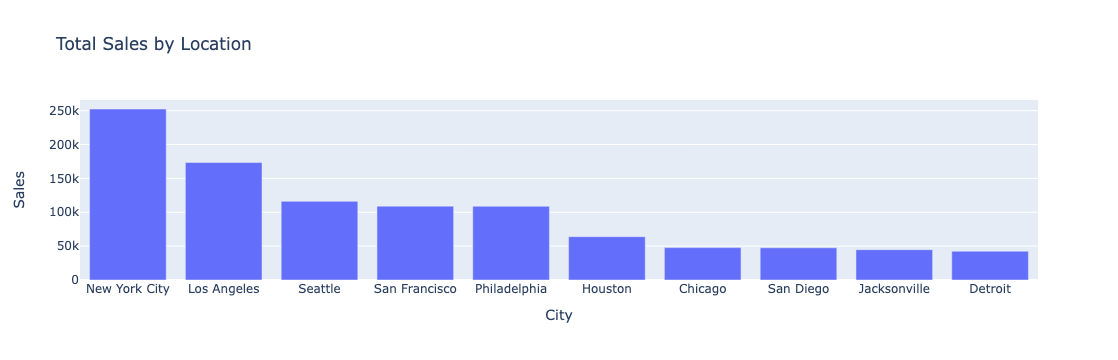

In [20]:
#Top 10 Cities with highest orders 

grouped_sales= df.groupby('City',as_index=False)['Sales'].sum()
sorted_sales = grouped_sales.sort_values(by='Sales', ascending=False).head(10)
fig = px.bar(sorted_sales, x='City', y='Sales', title='Total Sales by Location')
fig.show()



## Sales Distribution Across States
This bar chart shows the total sales distributed across the top states. California and New York stand out with significantly higher sales volumes compared to other states, reflecting their major role in market.


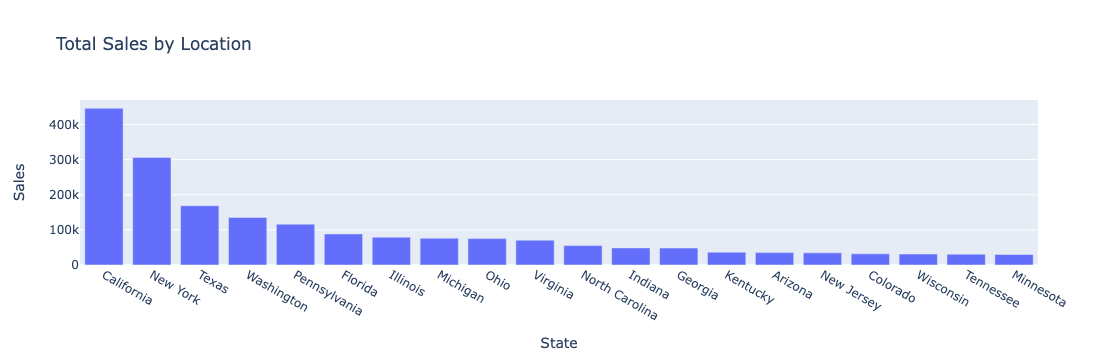

In [21]:
#Top 10 States with highest orders 

grouped_sales= df.groupby('State',as_index=False)['Sales'].sum()
sorted_sales = grouped_sales.sort_values(by='Sales', ascending=False).head(20)
fig = px.bar(sorted_sales, x='State', y='Sales', title='Total Sales by Location')
fig.show()

## Distribution of Ordered Products by Category
The pie chart illustrates the proportion of orders across different product categories. The majority of orders consist of Office Supplies, making up over 60% of total orders. Furniture accounts for about 21.2%, and Technology products make up 18.5%. 


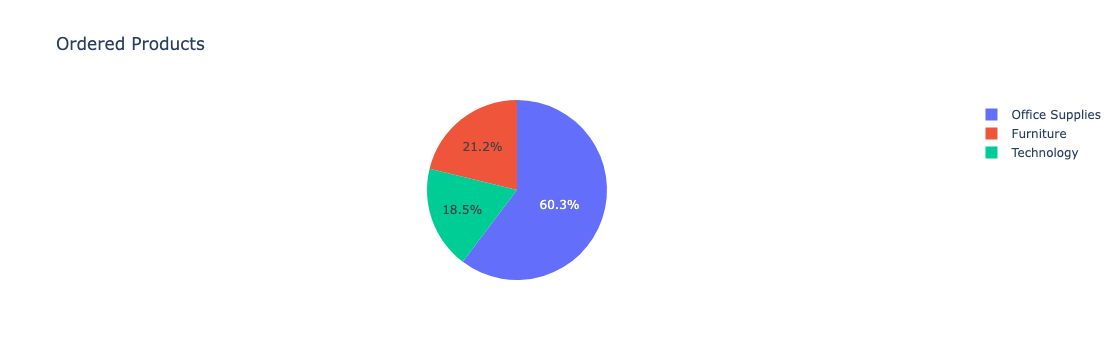

In [22]:
#Top frequently ordered Products

frequent_products=df['Category'].value_counts().reset_index()
frequent_products
fig=px.pie(frequent_products, names ='Category',  values='count', title='Ordered Products')
fig.show()

## Distribution of Ordered Sub-Products
The pie chart represents the frequency of orders for various sub-products. Binders and Paper are the most frequently ordered items, highlighting their essential role in everyday business operations. 



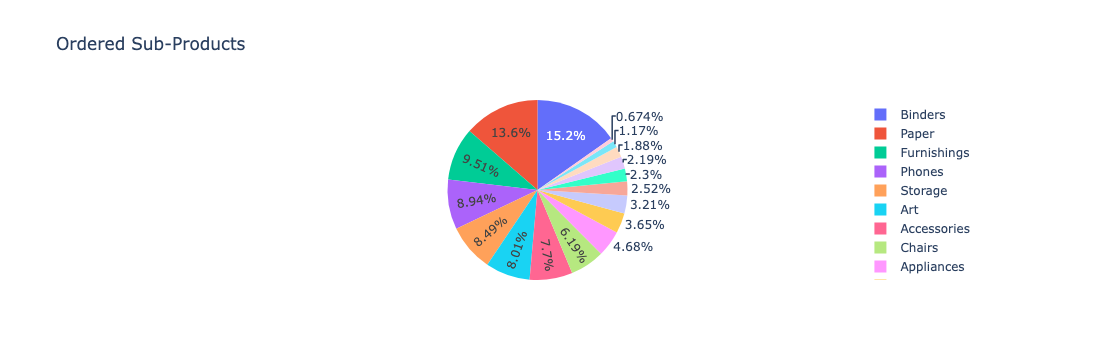

In [22]:
#Top frequently ordered Sub-Products

frequent_subcategories=df['Sub-Category'].value_counts().reset_index()
fig=px.pie(frequent_subcategories, names ='Sub-Category',  values='count', title='Ordered Sub-Products')
fig.show()

## Revenue Distribution Among Product Categories
The pie chart showcases the revenue shares from Technology, Furniture, and Office Supplies. The categories are closely competitive, with Technology slightly leading at 36.7%, followed closely by Furniture at 32.1%, and Office Supplies at 31.2%. Each category is vital and should be strategically managed to maintain this balance. Special attention might be required for promotions and stock management to maximize the profitability of each category.


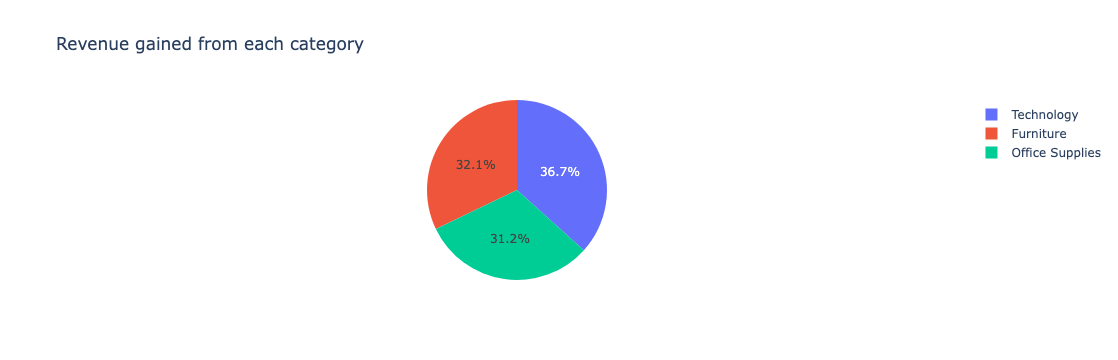

In [23]:
#Revenue gained from each category
grouped_data=df.groupby('Category',as_index=False)['Sales'].sum()
fig=px.pie(grouped_data,names='Category', values='Sales', title='Revenue gained from each category')
fig.show()

## Sales Trends Over the Years by Category
The line chart illustrates the sales trends from 2015 to 2018 across three main categories: Technology, Furniture, and Office Supplies.

Observations:
- **Technology's Growth:** Sales in the Technology category show a strong upward trajectory, indicating increasing market demand or successful market penetration strategies over the years.
- **Steady Increase in Furniture Sales:** Furniture sales have also shown a consistent rise, suggesting steady market growth or successful expansion in product offerings.
- **Office Supplies:** While the sales for Office Supplies are relatively stable, there is a slight upward trend, indicating gradual growth.



/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



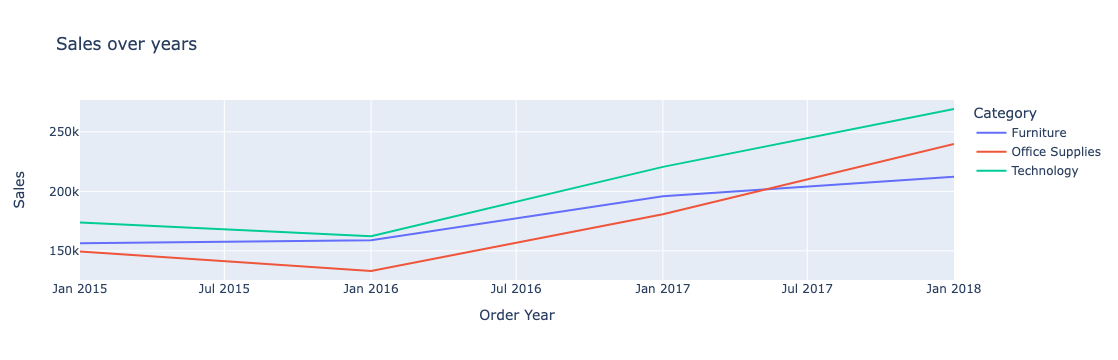

In [23]:
#Sales over years for each Category
df['Order Year'] = pd.to_datetime(df['Order Year'], format='%Y')
grouped_data= df.groupby(['Order Year','Category'],as_index=False)['Sales'].sum()
fig=px.line(grouped_data, x='Order Year', y='Sales',color='Category', title='Sales over years')
fig.show()

## Sales Analysis by Shipping Mode and Product Category
The stacked bar chart displays the sales distribution across different shipping modes—Standard, Second Class, First Class, and Same Day—for each product category: Technology, Furniture, and Office Supplies.

The majority of sales across all categories are made through Standard shipping, which underscores its preference due to lower costs or acceptable delivery timelines.While less total volume, the proportion of sales in the faster shipping categories remains consistent across the product types, indicating a steady demand pattern irrespective of shipping speed.

Strategic Considerations: Analyzing the costs versus benefits of different shipping modes could help in tailoring the options offered to customers, potentially enhancing satisfaction and repeat business.

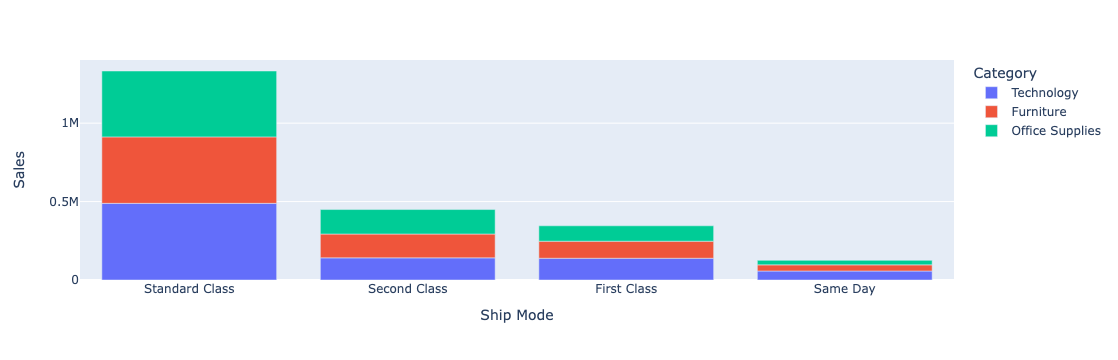

In [24]:
#Sales based on shipmode and Category of the products 

grouped_df= df.groupby(['Ship Mode','Category'], as_index=False)['Sales'].sum().round(0)
grouped_df= grouped_df.sort_values('Sales',ascending=False)
fig=px.bar(grouped_df, x= 'Ship Mode', y='Sales', color='Category')
fig.show()

## Weekly Sales Distribution
This bar chart illustrates the sales distribution across different days of the week, indicating varying consumer purchasing behaviors.

Observations:
- **Weekend Surge:** Saturday shows the highest sales, suggesting that customers tend to shop more during the weekend, possibly due to free time or promotional activities typically scheduled for weekends.
- **Midweek Trends:** Sales remain relatively high on weekdays, with Tuesday also showing significant activity, possibly driven by weekly sales promotions or restocking schedules that attract buyers.
- **Lower Sales on Thursday:** Thursday shows a dip in sales, which could indicate a midweek slowdown before picking up again towards the weekend.

Strategic Considerations:
- **Target Promotions:** Considering the spikes on Saturday and Tuesday, these days could be targeted for special promotions and major marketing campaigns to maximize revenue.



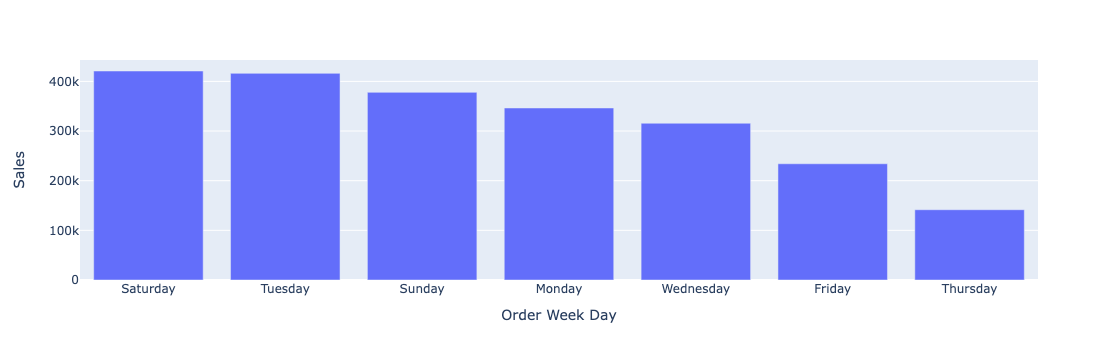

In [25]:
#Sales based on weekdays
grouped_df=df.groupby('Order Week Day', as_index=False)['Sales'].sum().round(0)
grouped_df= grouped_df.sort_values('Sales', ascending=False)
fig=px.bar(grouped_df, x='Order Week Day', y='Sales')
fig.show()

## Trend Analysis of Daily Sales
This line chart tracks the daily sales over several years, overlayed with a 30-day moving average that helps in identifying underlying trends beyond daily fluctuations.

Observations:
Daily sales represented by blue line shows considerable variability, with noticeable spikes, likely corresponding to promotional events or seasonal peaks. The moving average, represented by the red line, shows a relatively stable trend with gentle rises and dips. Only increase in sales can be seen near end of each year. This suggests to check any kind of seasonalities.

Strategic Considerations:
- **Marketing Campaigns:** Time promotional events or discounts to precede expected spikes to maximize sales and customer engagement.
- **Long-term Planning:** Use the stable trends indicated by the moving average for more reliable forecasting and strategic planning.


/opt/anaconda3/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



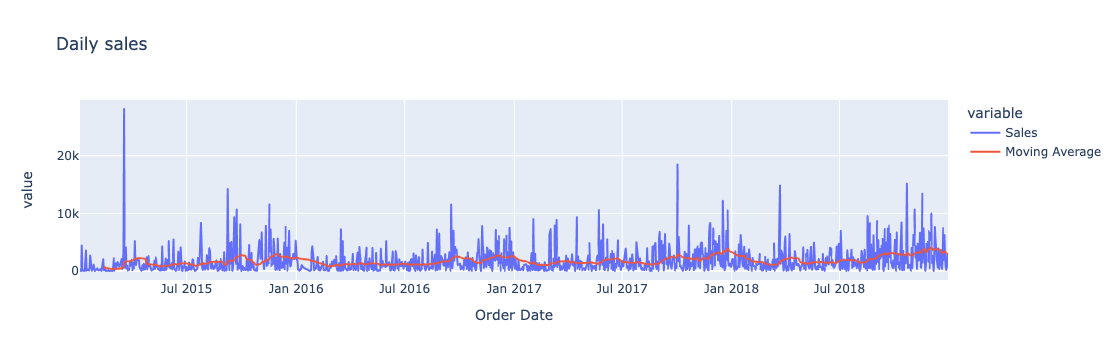

In [28]:
#Daily sales over time 
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()
daily_sales['Moving Average'] = daily_sales['Sales'].rolling(window=30).mean() 
fig=px.line(daily_sales, x='Order Date', y=['Sales', 'Moving Average'], title= 'Daily sales')
fig.show()

## Time Series Forecasting with Prophet
We employed the Prophet forecasting model to predict future sales based on historical data. Prophet is typically robust to missing data and shifts in the trend, and it automatically detects seasonal patterns, which makes it a powerful tool for this kind of time series analysis.

### Model Setup and Initial Results
The initial setup of the Prophet model was straightforward, involving fitting the model to our daily sales data. However, the initial forecasts were not satisfactory as the model failed to capture the underlying trends and seasonalities accurately.

### Error Metrics Evaluation
To quantitatively assess the model’s performance, we calculated various error metrics such as MAE (Mean Absolute Error), MSE (Mean Squared Error), and MAPE (Mean Absolute Percentage Error). These metrics indicated high error rates, suggesting that the model did not learn well from our data.

### Adjustments and Further Testing
In response to the initial results, we experimented with adjusting the model’s parameters, especially the seasonalities. We tried different configurations for yearly, weekly, and daily seasonalities to better align with our sales patterns. Despite these adjustments, the model's performance did not improve significantly.

### Insights and Possible Reasons
- **Data Characteristics:** The nature of our sales data, which includes irregular spikes and possibly non-stationary behaviors, may not be ideally suited for Prophet without extensive preprocessing or feature engineering.
- **Model Limitations:** Prophet might have limitations in capturing complex patterns without custom modifications to its standard components like holidays or additional regressors.



In [29]:
#Creating required dataframe for Prophet forecasting 
daily_sales_prophet_initial_data=daily_sales.drop(columns=['Moving Average']).rename(columns={'Order Date': 'ds', 'Sales':'y'})
daily_sales_prophet_initial_data

ds          y
0    2015-01-03    16.4480
1    2015-01-04   288.0600
2    2015-01-05    19.5360
3    2015-01-06  4407.1000
4    2015-01-07    87.1580
...         ...        ...
1224 2018-12-26   814.5940
1225 2018-12-27   177.6360
1226 2018-12-28  1657.3508
1227 2018-12-29  2915.5340
1228 2018-12-30   713.7900

[1229 rows x 2 columns]

In [30]:
#Spliting train and test set
split_index = int(0.8 * len(daily_sales_prophet_initial_data))
train_df = daily_sales_prophet_initial_data[:split_index]
test_df = daily_sales_prophet_initial_data[split_index:]


In [31]:
test_df

ds          y
983  2018-04-07  1971.2905
984  2018-04-08  6401.9300
985  2018-04-09  1626.7100
986  2018-04-10   755.5290
987  2018-04-11   319.8060
...         ...        ...
1224 2018-12-26   814.5940
1225 2018-12-27   177.6360
1226 2018-12-28  1657.3508
1227 2018-12-29  2915.5340
1228 2018-12-30   713.7900

[246 rows x 2 columns]

In [32]:
#Finding highest treshhold for removing outliers
Q1 = np.percentile(train_df['y'], 25)
Q3 = np.percentile(train_df['y'], 75)
IQR = Q3 - Q1
upper_threshold = Q3 + 1.5 * IQR
upper_threshold

4895.254500000001

In [33]:
#Filtering train set(removing outliers)
filtered_train_df = train_df[train_df['y'] <= upper_threshold]

In [34]:
#Creating Prophet model
model=Prophet()
model.fit(filtered_train_df)

01:53:06 - cmdstanpy - INFO - Chain [1] start processing
01:53:06 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
#Predict test set 
predicted_test_set=model.predict(test_df)
predicted_test_set

ds        trend  yhat_lower   yhat_upper  trend_lower  \
0   2018-04-07  1433.029266  195.943054  2887.026741  1433.029266   
1   2018-04-08  1433.431224  119.018757  2873.507731  1433.431224   
2   2018-04-09  1433.833183 -179.340685  2758.183478  1433.833183   
3   2018-04-10  1434.235141  128.819414  2995.410342  1434.235141   
4   2018-04-11  1434.637100   -9.521437  2840.903147  1434.637100   
..         ...          ...         ...          ...          ...   
241 2018-12-26  1538.744344  421.927446  3113.843076  1538.744235   
242 2018-12-27  1539.146303   78.438591  2822.746539  1539.146192   
243 2018-12-28  1539.548261   47.895455  2913.865216  1539.548150   
244 2018-12-29  1539.950220  444.837501  3269.596265  1539.950108   
245 2018-12-30  1540.352178  313.793683  3050.027435  1540.352066   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    1433.029266      101.038603            101.038603            101.038603   
1    1433.431224       55.678918             55.678918             55.678918   
2    1433.833183     -107.824780           -107.824780           -107.824780   
3    1434.235141      107.968811            107.968811            107.968811   
4    1434.637100       46.119381             46.119381             46.119381   
..           ...             ...                   ...                   ...   
241  1538.744456      284.221921            284.221921            284.221921   
242  1539.146415     -131.443759           -131.443759           -131.443759   
243  1539.548374      -64.866265            -64.866265            -64.866265   
244  1539.950333      290.079516            290.079516            290.079516   
245  1540.352292      188.388845            188.388845            188.388845   

         weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
0    193.848502    193.848502    193.848502  -92.809899    -92.809899   
1    132.910392    132.910392    132.910392  -77.231474    -77.231474   
2    -46.858669    -46.858669    -46.858669  -60.966111    -60.966111   
3    152.381107    152.381107    152.381107  -44.412296    -44.412296   
4     74.098696     74.098696     74.098696  -27.979315    -27.979315   
..          ...           ...           ...         ...           ...   
241   74.098696     74.098696     74.098696  210.123225    210.123225   
242 -305.549234   -305.549234   -305.549234  174.105474    174.105474   
243 -200.830794   -200.830794   -200.830794  135.964529    135.964529   
244  193.848502    193.848502    193.848502   96.231014     96.231014   
245  132.910392    132.910392    132.910392   55.478454     55.478454   

     yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0      -92.809899                   0.0                         0.0   
1      -77.231474                   0.0                         0.0   
2      -60.966111                   0.0                         0.0   
3      -44.412296                   0.0                         0.0   
4      -27.979315                   0.0                         0.0   
..            ...                   ...                         ...   
241    210.123225                   0.0                         0.0   
242    174.105474                   0.0                         0.0   
243    135.964529                   0.0                         0.0   
244     96.231014                   0.0                         0.0   
245     55.478454                   0.0                         0.0   

     multiplicative_terms_upper         yhat  
0                           0.0  1534.067869  
1                           0.0  1489.110142  
2                           0.0  1326.008403  
3                           0.0  1542.203952  
4                           0.0  1480.756481  
..                          ...          ...  
241                         0.0  1822.966265  
242                         0.0  1407.702544  
243                         0.0  1474.681996  
244                   

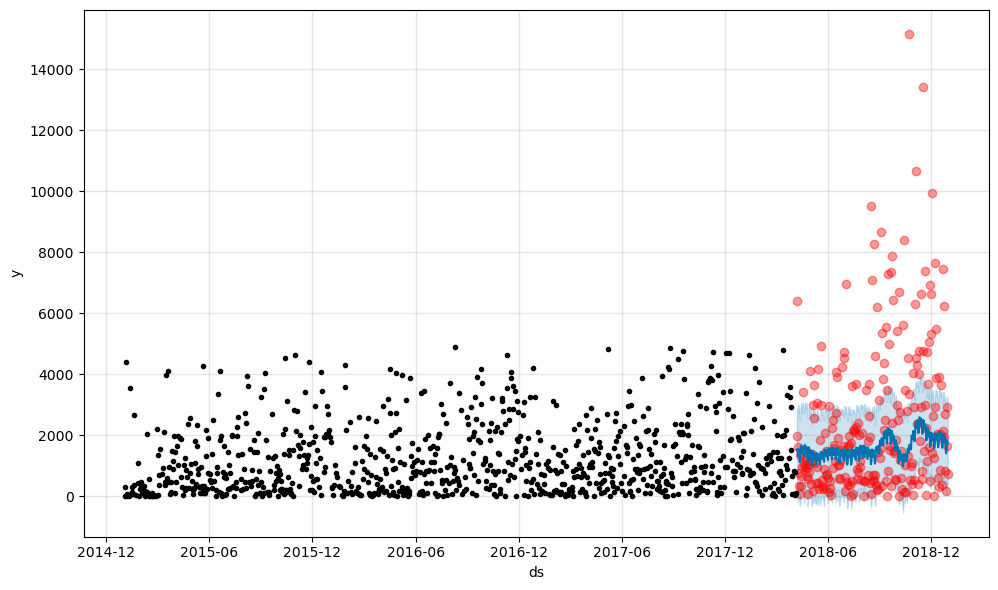

In [42]:
fig1 = model.plot(predicted_test_set)
plt.scatter(test_df['ds'], test_df['y'], color='red', alpha=0.4)
#start_date = pd.to_datetime('2018-06-01')
#end_date = pd.to_datetime('2018-12-02')
#plt.xlim(start_date, end_date)
#plt.ylim(min_x, max_x)
plt.show()

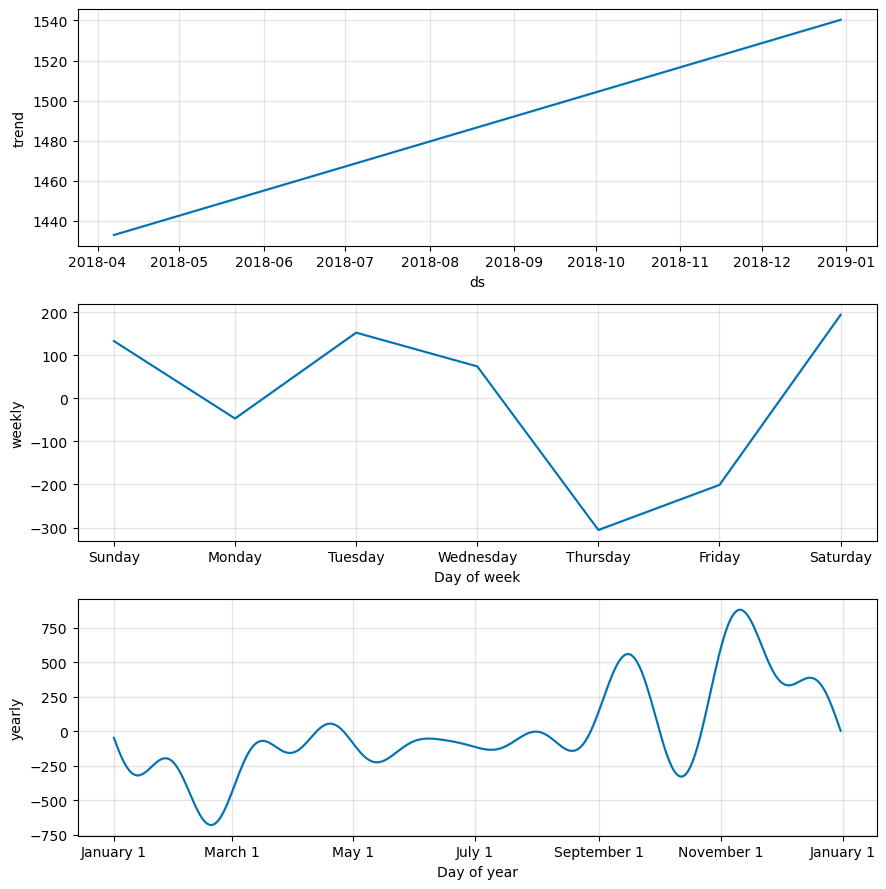

In [38]:
# Plot components of predicted model for test data
fig2=model.plot_components(predicted_test_set)

In [39]:
#Finding y_true and y_pred for error calculations 
y_true = test_df['y'].values
y_pred= predicted_test_set['yhat'].values

# Mean absolute error (MAE)
mae = mean_absolute_error(y_true, y_pred)

# Root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_true, y_pred)


print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 1636.9743424785868
RMSE: 2495.4352739401825
MAPE: 4.583069094706871


01:53:56 - cmdstanpy - INFO - Chain [1] start processing
01:53:56 - cmdstanpy - INFO - Chain [1] done processing


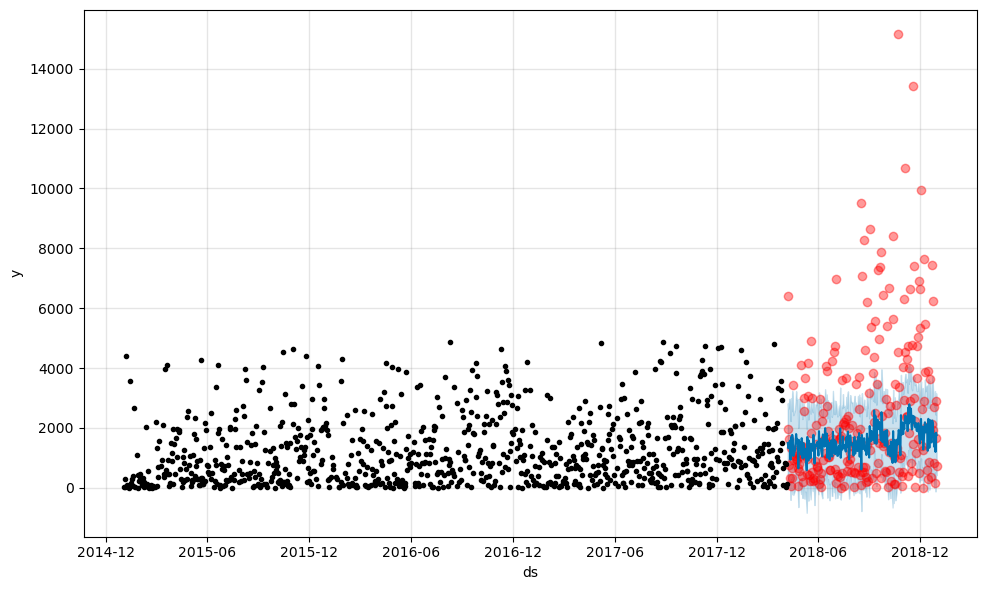

In [43]:
# Applying model prophet with seasonality (because in its normal form MAE and RMSE shoed relatively high values)

model_monthly=Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model_monthly.add_seasonality(name='monthly', period=30.5, fourier_order=20)
model_monthly.fit(filtered_train_df)
predicted_test_set_yearly_seasonality=model_monthly.predict(test_df)


# Sketching graphs to see the model visually
fig2 = model_monthly.plot(predicted_test_set_yearly_seasonality)
plt.scatter(test_df['ds'], test_df['y'], color='red', alpha=0.4)
plt.show()


In [41]:
# Checking errors for Prophet with yearly seosanlity

#Finding y_true and y_pred for error calculations 
y_true = test_df['y'].values
y_pred= predicted_test_set_yearly_seasonality['yhat'].values

# Mean absolute error (MAE)
mae_yearly_seasonality = mean_absolute_error(y_true, y_pred)

# Root mean squared error (RMSE)
rmse_yearly_seasonality = np.sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Percentage Error (MAPE)
mape_yearly_seasonality = mean_absolute_percentage_error(y_true, y_pred)


print("MAE:", mae_yearly_seasonality)
print("RMSE:", rmse_yearly_seasonality)
print("MAPE:", mape_yearly_seasonality)

MAE: 1657.2875895290185
RMSE: 2505.288250862763
MAPE: 4.704512231555904


01:54:06 - cmdstanpy - INFO - Chain [1] start processing
01:54:06 - cmdstanpy - INFO - Chain [1] done processing


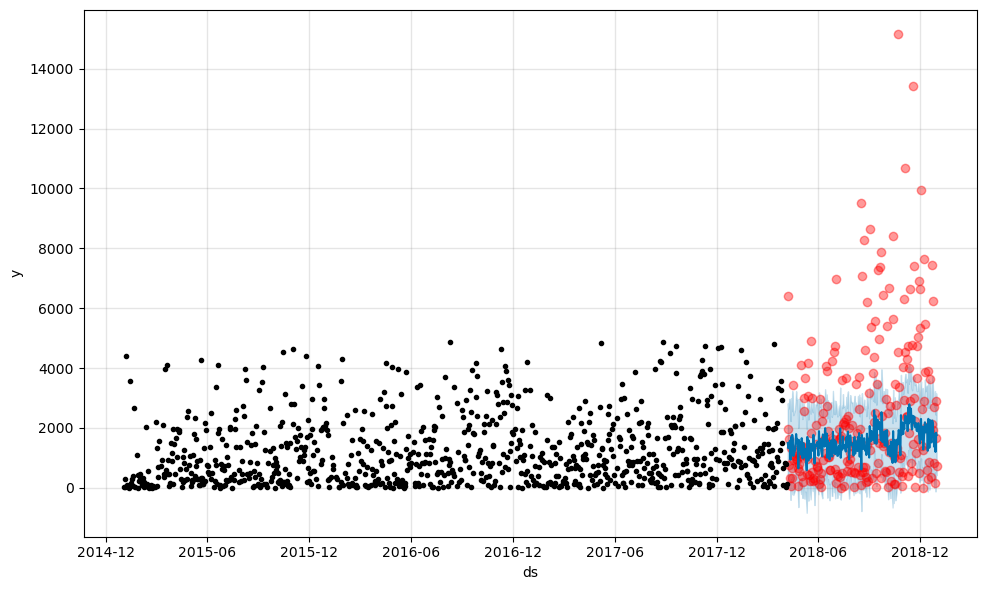

In [45]:
# Applying model prophet with daily seasonality (because in its normal form MAE and RMSE shoed relatively high values)

model_daily=Prophet(daily_seasonality=True)
model_daily.fit(filtered_train_df)
predicted_test_set_daily_seasonality=model_daily.predict(test_df)


# Sketching graphs to see the model visually
fig3 = model_daily.plot(predicted_test_set_yearly_seasonality)
plt.scatter(test_df['ds'], test_df['y'], color='red', alpha=0.4)
plt.show()



In [46]:
# Checking errors for Prophet with yearly seosanlity

#Finding y_true and y_pred for error calculations 
y_true = test_df['y'].values
y_pred= predicted_test_set_daily_seasonality['yhat'].values

# Mean absolute error (MAE)
mae_daily_seasonality = mean_absolute_error(y_true, y_pred)

# Root mean squared error (RMSE)
rmse_daily_seasonality = np.sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Percentage Error (MAPE)
mape_daily_seasonality = mean_absolute_percentage_error(y_true, y_pred)


print("MAE:", mae_daily_seasonality)
print("RMSE:", rmse_daily_seasonality)
print("MAPE:", mape_daily_seasonality)

MAE: 1636.860358072786
RMSE: 2497.478517003347
MAPE: 4.559545361545586
